### Install & Import Required Libraries

In [5]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium  # For map visualization
import plotly.express as px
from folium.plugins import HeatMap

import warnings
warnings.simplefilter("ignore")

### Load & Explore the Dataset

In [3]:
# Load dataset
df = pd.read_csv("US_Accidents_March23.csv")

# Take a random sample of 50,000 rows
df_sample = df.sample(n=50000, random_state=42)

# Display sampled data
print(df_sample.shape)
print(df_sample.head())


(50000, 46)
                ID   Source  Severity                     Start_Time  \
7133276  A-7182628  Source1         1            2020-04-17 09:29:30   
5363845  A-5404588  Source1         2  2022-04-21 10:01:00.000000000   
155993    A-156000  Source3         3            2016-08-12 16:45:00   
1861414  A-1871277  Source2         3            2019-09-20 15:22:16   
2021359  A-2031222  Source2         2            2019-06-03 16:55:43   

                              End_Time  Start_Lat   Start_Lng    End_Lat  \
7133276            2020-04-17 10:29:30  26.706900  -80.119360  26.706900   
5363845  2022-04-21 11:44:08.000000000  38.781024 -121.265820  38.780377   
155993             2016-08-12 17:15:00  33.985249  -84.269348        NaN   
1861414            2019-09-20 15:56:00  47.118706 -122.556908        NaN   
2021359            2019-06-03 18:12:09  33.451355 -111.890343        NaN   

            End_Lng  Distance(mi)  ... Roundabout Station   Stop  \
7133276  -80.119360         0.

- The dataset contains traffic accident details across the US.
- We will focus on weather, road conditions, and time factors.

### Data Cleaning & Preprocessing

In [6]:
# Drop irrelevant columns
df = df[["Severity", "Start_Time", "Start_Lat", "Start_Lng", "City", "State", "Temperature(F)", 
         "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition"]]

# Convert 'Start_Time' to datetime format
df["Start_Time"] = pd.to_datetime(df["Start_Time"])

# Extract Hour, Month, and Day of the Week
df["Hour"] = df["Start_Time"].dt.hour
df["Month"] = df["Start_Time"].dt.month
df["DayOfWeek"] = df["Start_Time"].dt.dayofweek

# Fill missing values with median (for numerical columns)
df.fillna(df.median(), inplace=True)

# Fill missing 'Weather_Condition' with 'Unknown'
df["Weather_Condition"].fillna("Unknown", inplace=True)

# Display cleaned dataset
print(df.head())


   Severity          Start_Time  Start_Lat  Start_Lng          City State  \
0         3 2016-02-08 05:46:00  39.865147 -84.058723        Dayton    OH   
1         2 2016-02-08 06:07:59  39.928059 -82.831184  Reynoldsburg    OH   
2         2 2016-02-08 06:49:27  39.063148 -84.032608  Williamsburg    OH   
3         3 2016-02-08 07:23:34  39.747753 -84.205582        Dayton    OH   
4         2 2016-02-08 07:39:07  39.627781 -84.188354        Dayton    OH   

   Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
0            36.9         91.0         29.68            10.0              7.0   
1            37.9        100.0         29.65            10.0              7.0   
2            36.0        100.0         29.67            10.0              3.5   
3            35.1         96.0         29.64             9.0              4.6   
4            36.0         89.0         29.65             6.0              3.5   

  Weather_Condition  Hour  Month  DayOfWeek  
0   

### Fixes Applied:

- Dropped irrelevant columns for analysis.
- Extracted time-related features (Hour, Month, Day of the Week).
- Handled missing values (numerical columns filled with median).

### Analyzing Accidents by Time of Day

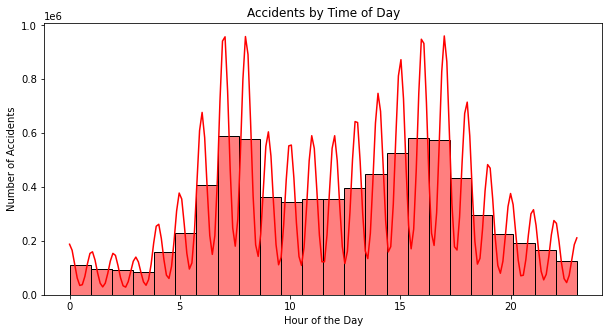

In [7]:
# Count of accidents per hour
plt.figure(figsize=(10, 5))
sns.histplot(df["Hour"], bins=24, kde=True, color="red")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Time of Day")
plt.show()


### Analyzing Accidents by Weather Conditions


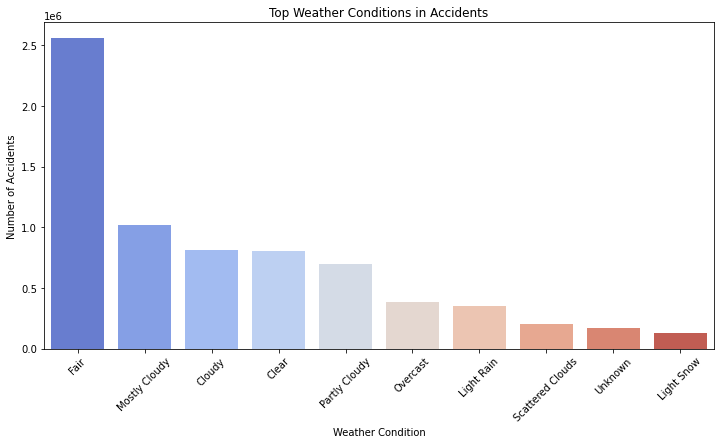

In [8]:
# Top 10 weather conditions
top_weather = df["Weather_Condition"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_weather.index, y=top_weather.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.title("Top Weather Conditions in Accidents")
plt.show()


### Findings:

- Rain, fog, and snow increase accident risk due to poor visibility

### Accident Hotspot Visualization (Heatmap)

In [9]:
# Sample 50,000 accidents for faster processing
df_sample = df.sample(50000)

# Create a map centered in the US
accident_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add a heatmap layer
HeatMap(data=df_sample[["Start_Lat", "Start_Lng"]], radius=8).add_to(accident_map)

# Display map
accident_map


### Findings:

- Hotspots appear in major cities & highways where traffic is high.

### Impact of Road & Weather Conditions on Accident Severity

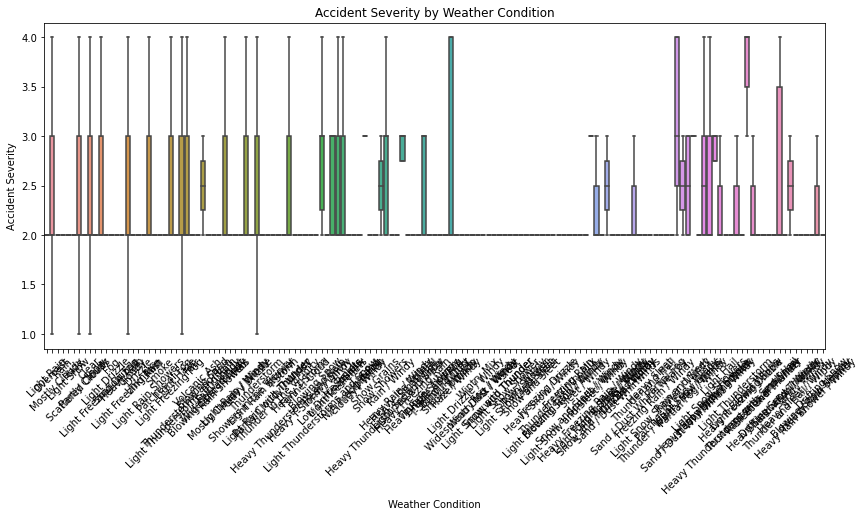

In [10]:
# Plot accident severity distribution across weather conditions
plt.figure(figsize=(14, 6))
sns.boxplot(x="Weather_Condition", y="Severity", data=df, showfliers=False)
plt.xticks(rotation=45)
plt.xlabel("Weather Condition")
plt.ylabel("Accident Severity")
plt.title("Accident Severity by Weather Condition")
plt.show()


### Findings:

- Snow, fog, and heavy rain lead to more severe accidents.

### Analyzing Accidents by State

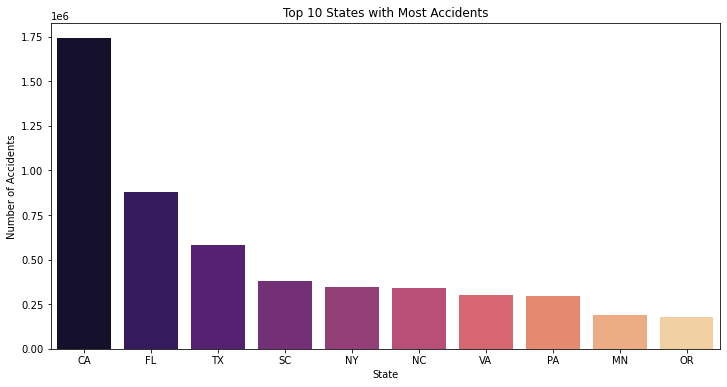

In [11]:
# Top 10 states with highest accidents
state_counts = df["State"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="magma")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.title("Top 10 States with Most Accidents")
plt.show()


### Findings:

California, Texas, and Florida have the most accidents

### Visualizing Accidents on a US Map

In [12]:
# Aggregate accident count by state
state_accidents = df.groupby("State")["Severity"].count().reset_index()

# US Map Visualization
fig = px.choropleth(state_accidents, 
                    locations="State", 
                    locationmode="USA-states",
                    color="Severity",
                    scope="usa",
                    color_continuous_scale="reds",
                    title="Traffic Accidents Across US States")

fig.show()


### Findings:

Darker regions represent states with more accidents

### Final Summary & Next Steps
- Identified peak accident times (morning & evening rush hours).
- Analyzed impact of weather (fog, rain, snow) on accident severity.
- Visualized accident hotspots using heatmaps & choropleth maps.
- Found that California, Texas, and Florida have the highest accidents.

In [13]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
# Select features & target variable
features = ["Start_Lat", "Start_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
            "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition", "Hour", "DayOfWeek"]

target = "Severity"

# Convert 'Start_Time' to datetime and extract useful time features
df_sample["Start_Time"] = pd.to_datetime(df_sample["Start_Time"])
df_sample["Hour"] = df_sample["Start_Time"].dt.hour
df_sample["DayOfWeek"] = df_sample["Start_Time"].dt.dayofweek

# Fill missing numerical values with median
df_sample.fillna(df_sample.median(), inplace=True)

# Fill missing 'Weather_Condition' with "Unknown"
df_sample["Weather_Condition"].fillna("Unknown", inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
df_sample["Weather_Condition"] = encoder.fit_transform(df_sample["Weather_Condition"])

# Define features & target
X = df_sample[features]
y = df_sample[target]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display dataset shape
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (40000, 10)
Testing Data Shape: (10000, 10)


### Fixes Applied:

- Selected relevant columns (weather, time, road conditions).
- Extracted ‘Hour’ and ‘DayOfWeek’ from timestamps.
- Encoded categorical features (Weather_Condition).
- Standardized numerical data for better ML performance.

### Train a Random Forest Classifier

In [17]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f" Random Forest Accuracy: {rf_accuracy:.2f}")

# Classification Report
print("\n Classification Report:\n", classification_report(y_test, y_pred_rf))


 Random Forest Accuracy: 0.80

 Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        91
           2       0.80      1.00      0.89      7999
           3       0.55      0.02      0.04      1651
           4       0.00      0.00      0.00       259

    accuracy                           0.80     10000
   macro avg       0.34      0.25      0.23     10000
weighted avg       0.73      0.80      0.72     10000



In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate performance
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f" Gradient Boosting Accuracy: {gb_accuracy:.2f}")

# Classification Report
print("\n Classification Report:\n", classification_report(y_test, y_pred_gb))


 Gradient Boosting Accuracy: 0.80

 Classification Report:
               precision    recall  f1-score   support

           1       0.12      0.01      0.02        91
           2       0.80      0.99      0.89      7999
           3       0.52      0.03      0.06      1651
           4       0.00      0.00      0.00       259

    accuracy                           0.80     10000
   macro avg       0.36      0.26      0.24     10000
weighted avg       0.73      0.80      0.72     10000



### Compare Model Performance

In [21]:
# Compare accuracy of models
print(" Model Comparison:")
print(f" Random Forest Accuracy: {rf_accuracy:.2f}")
print(f" Gradient Boosting Accuracy: {gb_accuracy:.2f}")


 Model Comparison:
 Random Forest Accuracy: 0.80
 Gradient Boosting Accuracy: 0.80


 ### Predict Accident Severity for New Data

In [23]:
# Example new accident data (Ensure it has same features as X)
new_accident = np.array([[40.7128, -74.0060, 55, 80, 30, 5, 10, 3, 18, 2]])  # Example accident

# Transform using trained scaler
new_accident_scaled = scaler.transform(new_accident)

# Predict severity
prediction = gb_model.predict(new_accident_scaled)

# Output prediction
print(f"Predicted Severity Level: {prediction[0]}")


Predicted Severity Level: 2
